# Deep CNN for computer vision

In [3]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from utils import show_images


# autoreload ALL modules in real time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Your imports

num_workers = 2     # maximum number of subprocces (check https://pytorch.org/docs/stable/data.html for more info)
batch_size = 16     # increase or decrease batch_size here


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cuda:1 device


# Task #1: Basic Pipeline [3 points]

## Step 1: Data Preparation

### Load [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) from torchvision.datasets

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

root = '../datasets/CIFAR10'

# download data
train_data = torchvision.datasets.CIFAR10(
    root=root, train=True, download=True, 
    transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root=root, train=False, download=True, 
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


### Create dataloaders and plot some examples

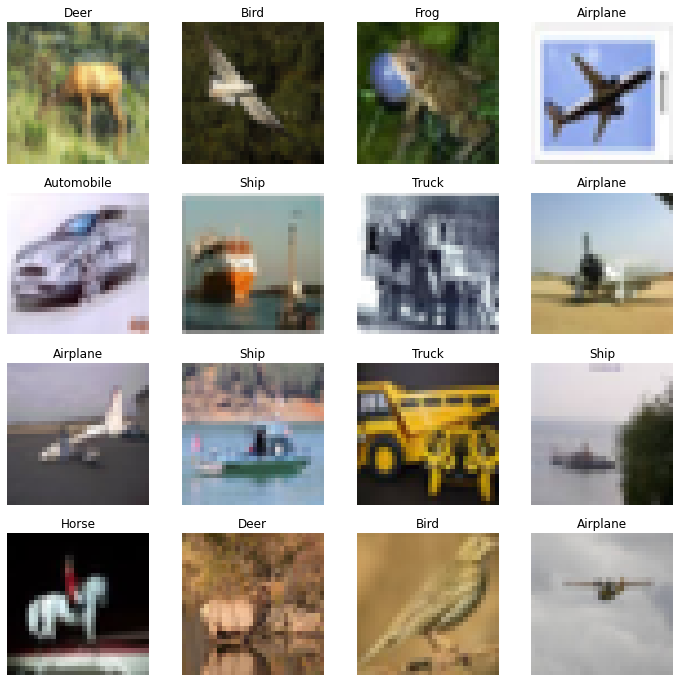

In [6]:
# create dataloaders for model
train_dataloader = torch.utils.data.DataLoader(
    train_data, shuffle=True, 
    batch_size=batch_size, num_workers=num_workers
)

test_dataloader = torch.utils.data.DataLoader(
    test_data, shuffle=True, 
    batch_size=batch_size, num_workers=num_workers
)

# show some images from CIFAR
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}

N_samples = 16
images, labels = next(iter(train_dataloader))
show_images(
    images[:N_samples], 
    [labels_map[i.item()] for i in labels[:N_samples]], 
    transform=transforms.ToPILImage()
)

**Hint!**

Use can use ```torchvision.utils.make_grid()``` for your own plots. Check [documentation](https://pytorch.org/vision/stable/utils.html) for examples.


## Step 2: Neural Network [1 point]


В этом задании вам предстоит заполнить пробелы в типичном pipeline для обучения нейросетей на pytorch. 

Для наглядности (и последующего сравнения с Deep CNN-сетями) будем использовать простейший перцептрон в качестве модели. 

**Hint!** Можно изменить размеры и число скрытых слоёв, передав в качестве аргумента ```blocks``` их список.

### NN Architecrute

In [5]:
from models import MLP

mlp = MLP(images[0].shape, n_classes=len(labels_map), blocks=[256, 512, 256, 128, 64]).to(device)

**Hint!** Можно обратиться к документации [pytorch](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) для примеров реализации функций ```train_loop()``` и ```test_loop()```.

### [1 point ] Train-test loops

In [7]:
import IPython
from math import ceil


def train_loop(model, dataloader, loss_fn, optimizer, step=0.05):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset) 
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1
    
    percentage = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)

        # evaluate
        model.train()
        optimizer.zero_grad()
        f = model(X)
        loss = loss_fn(f, y)
        
        # backpropagation
        loss.backward()
        optimizer.step()
        
        # print info
        if batch / batches > percentage or batch == batches: 
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
            percentage += step
        
        
def test_loop(model, dataloader, loss_fn):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    with torch.no_grad():
        # evalute and check predictions
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            f = model(X)
            test_loss += loss_fn(f, y)
            correct += (f.argmax(axis=1) == y).sum().item()
        
    test_loss /= batches
    correct /= size
    
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")

### [1 point] Learning curves

1. Модифицируйте функции ```train_loop()``` и ```test_loop()``` таким образом, чтобы они возвращали словарь ```history```, содержащий ключи ```val_acc```, ```val_loss```, ```train_acc``` и ```train_loss```. 

2. Постройте графики зависимости ```loss_fn``` и ```accuracy``` для обучающей и тестовой выборок от эпохи обучения.

**Hint!** Не стоит пропускать этот пункт: другие задания могут требовать наличия соответствующих графиков.

In [8]:
import IPython
from math import ceil


def train_loop(model, dataloader, loss_fn, optimizer, step=0.05):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset) 
    len_size = len(str(size))
    train_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size) - 1
    
    percentage = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)

        # evaluate
        model.train()
        optimizer.zero_grad()
        f = model(X)
        loss = loss_fn(f, y)
        train_loss += loss
        correct += (f.argmax(axis=1) == y).sum().item()
        
        # backpropagation
        loss.backward()
        optimizer.step()
        
        # print info
        if batch / batches > percentage or batch == batches: 
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
            percentage += step
            
    train_loss /= batches
    correct /= size
    return {'train_acc': correct, 'train_loss': train_loss.item()}
        
        
def test_loop(model, dataloader, loss_fn):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    with torch.no_grad():
        # evalute and check predictions
        model.eval()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            f = model(X)
            test_loss += loss_fn(f, y)
            correct += (f.argmax(axis=1) == y).sum().item()
        

    test_loss /= batches
    correct /= size
    
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")
    return {'val_acc': correct, 'val_loss': test_loss.item()}

## Step 3: Train Network

**Hint!** В качестве лосс-функции следует использовать ```CrossEntropy```, а в качестве оптимизитора - ```Adam```.

In [9]:
from dataclasses import dataclass
import typing as tp
    
class ModelInstance:
    def __init__(self, train_dataloader, test_dataloader, model, optimizer, loss_fn):
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        self.train_acc = []
        self.train_loss = []
        self.test_acc = []
        self.test_loss = []
        
    def run(self, epochs):
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            train_history = train_loop(self.model, self.train_dataloader, self.loss_fn, self.optimizer)
            test_history = test_loop(self.model, self.test_dataloader, self.loss_fn)

            self.train_acc.append(train_history['train_acc'])
            self.train_loss.append(train_history['train_loss'])
            self.test_acc.append(test_history['val_acc'])
            self.test_loss.append(test_history['val_loss'])
            
    def plot(self):
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        
        ax[0].set_title('Accuracy')
        ax[0].plot(self.train_acc, label='train_acc')
        ax[0].plot(self.test_acc, label='test_acc')
        ax[0].legend()
        ax[0].set_xlabel('Epoch')
        
        ax[1].set_title('Loss')
        ax[1].plot(self.train_loss, label='train_loss')
        ax[1].plot(self.test_loss, label='test_loss')
        ax[1].legend()
        ax[1].set_xlabel('Epoch')

In [64]:
# loss_fn, optimizer and number of epochs are required
net = ModelInstance(
    train_dataloader,
    test_dataloader,
    mlp,
    torch.optim.Adam(mlp.parameters()),
    nn.CrossEntropyLoss()
)

In [65]:
%time net.run(10)

Epoch 1
-------------------------------


'[50000/50000] Loss: 2.056973'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 23.5%, Validation loss: 2.115432 

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.852010'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 26.9%, Validation loss: 2.054731 

Epoch 3
-------------------------------


'[50000/50000] Loss: 2.125829'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 27.3%, Validation loss: 2.046293 

Epoch 4
-------------------------------


'[50000/50000] Loss: 2.048765'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 25.2%, Validation loss: 2.057143 

Epoch 5
-------------------------------


'[50000/50000] Loss: 2.093553'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 28.1%, Validation loss: 2.031963 

Epoch 6
-------------------------------


'[50000/50000] Loss: 2.242523'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 28.1%, Validation loss: 2.029562 

Epoch 7
-------------------------------


'[50000/50000] Loss: 2.380503'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 28.5%, Validation loss: 2.003777 

Epoch 8
-------------------------------


'[50000/50000] Loss: 1.760577'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 28.5%, Validation loss: 2.032034 

Epoch 9
-------------------------------


'[50000/50000] Loss: 1.939946'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 29.6%, Validation loss: 1.992151 

Epoch 10
-------------------------------


'[50000/50000] Loss: 2.133234'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 28.8%, Validation loss: 2.019696 

CPU times: user 3min, sys: 16.9 s, total: 3min 17s
Wall time: 3min 35s


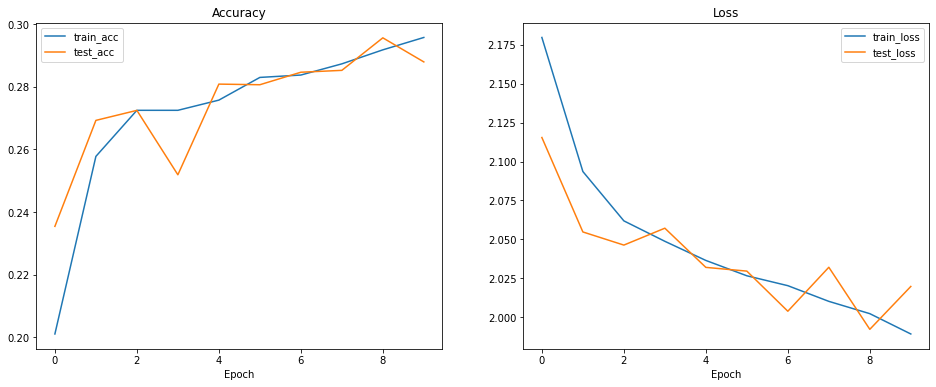

In [66]:
net.plot()

# Task #2: ResNet [4 points]

### [3 points: 1 for each correct class]

В этом задании от вас потребуется заполнить пропуски в ```./models/ResNet.py``` таким образом, чтобы полученная архитектура соответствовала ```resnet18```. Мы будем использовать именно эту модификацию архитектуры из-за её небольшого размера и относительной простоты самостоятельной реализации.

**Hint 0!**
В качестве примера можно опираться на соответствующую реализацию ```resnet18``` из **pytorch**.

**Hint 1!**
Благодаря **autoreload** вы можете использовать свежие изменения в ResNet.py без перезагрузки модуля. 

**Hint 2!**
Первым делом попробуйте сопоставить описанные классы с описанием встроенной в pytorch модели. Не забывайте про последовательную отладку.

In [10]:
%load_ext autoreload
%autoreload 2
from models import ResidualBlock, ResNetLayer, ResNet18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# test ResidualBlock shapes
assert ResidualBlock(64, 64)(torch.rand(1, 64, 32, 32)).shape == torch.Size([1, 64, 32, 32])
assert ResidualBlock(64, 128)(torch.rand(1, 64, 32, 32)).shape == torch.Size([1, 128, 16, 16])
assert ResidualBlock(128, 256)(torch.rand(100, 128, 16, 16)).shape == torch.Size([100, 256, 8, 8])

In [12]:
# test ResNetLayer shapes
assert ResNetLayer(64, 64)(torch.rand(1, 64, 32, 32)).shape == torch.Size([1, 64, 32, 32])
assert ResNetLayer(64, 128)(torch.rand(1, 64, 32, 32)).shape == torch.Size([1, 128, 16, 16])
assert ResNetLayer(128, 256)(torch.rand(100, 128, 16, 16)).shape == torch.Size([100, 256, 8, 8])

**Hint 3!**
Обратите внимание на структуру ```resnet18```. Первая часть (до появления ```ResNetLayer```) - это блок даунсэмплинга. Не забудьте модифицировать структуру сети так, чтобы она была применима к изображениям из **CIFAR10**. 

In [13]:
dummy = ResNet18()(images) # эта строчка не должна вызывать ошибку

Обучите свою модель в течении небольшого количества эпох (6-30). 

In [69]:
# loss_fn, optimizer and number of epochs are required
resnet18 = ResNet18().to(device)

resnet18_instance = ModelInstance(
    train_dataloader,
    test_dataloader,
    resnet18,
    torch.optim.Adam(resnet18.parameters()),
    nn.CrossEntropyLoss()
)

In [70]:
%time resnet18_instance.run(10)

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.152491'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 57.2%, Validation loss: 1.193285 

Epoch 2
-------------------------------


'[50000/50000] Loss: 0.782921'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 61.3%, Validation loss: 1.241004 

Epoch 3
-------------------------------


'[50000/50000] Loss: 0.543365'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 70.1%, Validation loss: 0.848686 

Epoch 4
-------------------------------


'[50000/50000] Loss: 0.609013'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 76.8%, Validation loss: 0.682945 

Epoch 5
-------------------------------


'[50000/50000] Loss: 0.833533'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 75.4%, Validation loss: 0.720837 

Epoch 6
-------------------------------


'[50000/50000] Loss: 0.691840'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 78.0%, Validation loss: 0.669223 

Epoch 7
-------------------------------


'[50000/50000] Loss: 0.387227'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 81.0%, Validation loss: 0.615547 

Epoch 8
-------------------------------


'[50000/50000] Loss: 0.012605'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 78.8%, Validation loss: 0.702297 

Epoch 9
-------------------------------


'[50000/50000] Loss: 0.452277'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 80.7%, Validation loss: 0.696417 

Epoch 10
-------------------------------


'[50000/50000] Loss: 0.320292'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 79.3%, Validation loss: 0.815777 

CPU times: user 17min 7s, sys: 53.6 s, total: 18min 1s
Wall time: 18min 5s


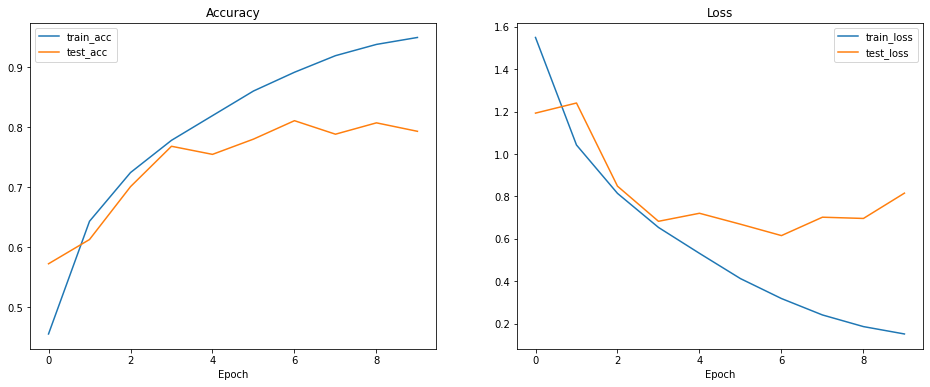

In [71]:
resnet18_instance.plot()

### [1 point]

Сравните процесс обучения свёрточной сети и перцептрона, а также число параметров. Какие выводы можно сделать?

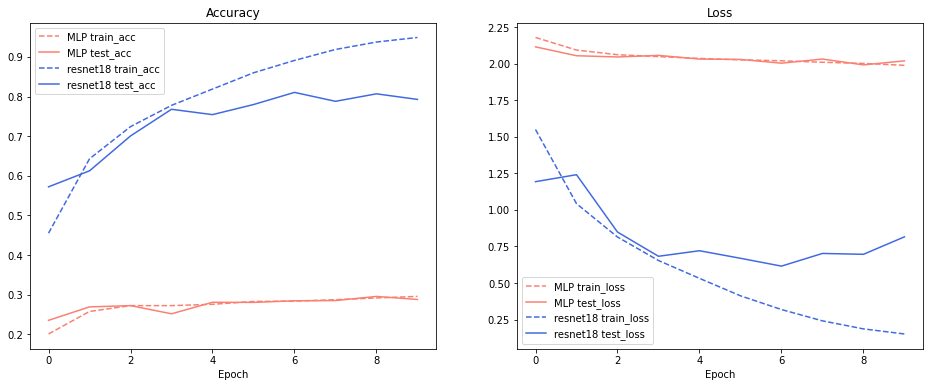

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        
ax[0].set_title('Accuracy')
ax[0].plot(net.train_acc, label='MLP train_acc', c='salmon', linestyle='--')
ax[0].plot(net.test_acc, label='MLP test_acc', c='salmon')
ax[0].plot(resnet18_instance.train_acc, label='resnet18 train_acc', c='royalblue', linestyle='--')
ax[0].plot(resnet18_instance.test_acc, label='resnet18 test_acc', c='royalblue')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].set_title('Loss')
ax[1].plot(net.train_loss, label='MLP train_loss', c='salmon', linestyle='--')
ax[1].plot(net.test_loss, label='MLP test_loss', c='salmon')
ax[1].plot(resnet18_instance.train_loss, label='resnet18 train_loss', c='royalblue', linestyle='--')
ax[1].plot(resnet18_instance.test_loss, label='resnet18 test_loss', c='royalblue')
ax[1].legend()
ax[1].set_xlabel('Epoch');

In [99]:
print(f'MLP parameters: {sum([_.numel() for _ in net.model.parameters()]) // 10**6} million')
print(f'Resnet18 parameters: {sum([_.numel() for _ in resnet18_instance.model.parameters()]) // 10**6} million')

MLP parameters: 1 million
Resnet18 parameters: 44 million


Несмотря на то, что у остаточной сверточной сети в десятки раз больше параметров, чем у перцептрона, она гораздо быстрее обучается. Можно сделать вывод, что у сверточной сети эффективнее получается извлекать информацию о закономерностях в данных. Эта разница обусловлена тем, что семейство функций, которые приближает остаточная сверточная сеть, ближе к истинным, чем семейство функций перцептрона, и ее можно охарактеризовать тремя основными отличиями:

1. Свертки учитывают пространственную компактность объектов в реальном мире, которая транслируется на двумерные изображения.
2. За счет батч нормализации градиенты доходят до всех слоев сети с меньшими потерями.
3. За счет прямых связей между слоями модель имеет меньшую дисперсию и смещена в сторону тождественного преобразования, что соотносится с тем, что в природе взаимосвязи в основном непрерывны и с уменьшением расстояния между двумя объектами природы отображение одного объекта в другое стремится к тождественному, например: чем меньше времени произошло между двумя состояниями природы, тем больше они похожи; чем ближе две области в пространстве, тем больше они похожи; чем больше в блюдах одинаковых ингредиентов, тем больше похожи их вкусы.

# Task #3: EfficientNet [3 points]

Иногда нет необходимости обучать модели "с нуля". Попробуем использовать для этой задачи технику, называющуюся **transfer learning**. В отличие от **fine tuning**, мы не будем переобучать всю сеть целиком. Вместо этого мы будем использовать уже предобученную сеть в качестве **fixed feature extractor**. 

Активации последнего свёрточного слоя мы будем использовать как уже готовые признаки. И уже на этих признаках мы обучим собственный классификатор, подходящий к нашей задаче.

Будем использовать обученную на датасете **ImageNet** сеть ```EfficientNet```. 

Чтобы адаптировать её к нашему датасету, потребуется **"заморозить" веса** и заменить классификатор модели. 

**Hint!** Обратитесь к документации [pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor) за подробностями. Обратите внимание, что мы **не переобучаем всю сеть целиком**.

## [1 point]

In [12]:
from torchvision.models import efficientnet_b0


# load and freeze pretrained model
efficientnet = efficientnet_b0(pretrained=True, progress=True)
for name, param in efficientnet.named_parameters():
    param.requires_grad = False

# change classifier
in_features = efficientnet.classifier[-1].in_features
efficientnet.classifier[-1] = nn.Linear(in_features, 10)

In [13]:
# loss_fn, optimizer and number of epochs are required
efficientnet = efficientnet.to(device)

efficientnet_instance = ModelInstance(
    train_dataloader,
    test_dataloader,
    efficientnet,
    torch.optim.Adam(efficientnet.parameters()),
    nn.CrossEntropyLoss()
)

In [16]:
%time efficientnet_instance.run(10)

Epoch 1
-------------------------------


'[7500/50000] Loss: 2.074711'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 

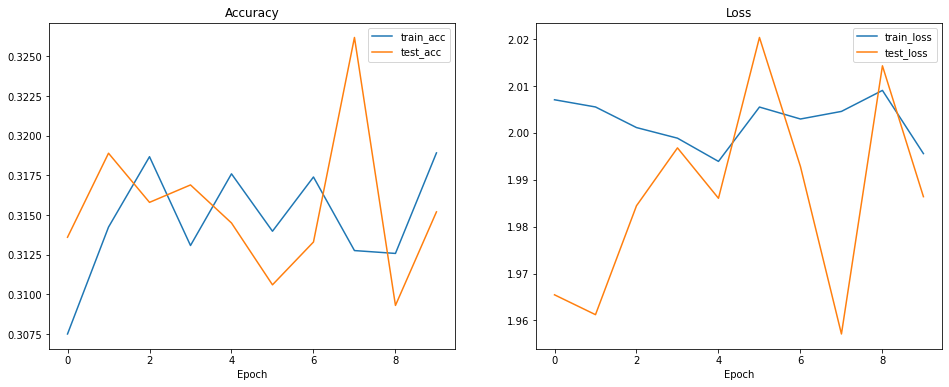

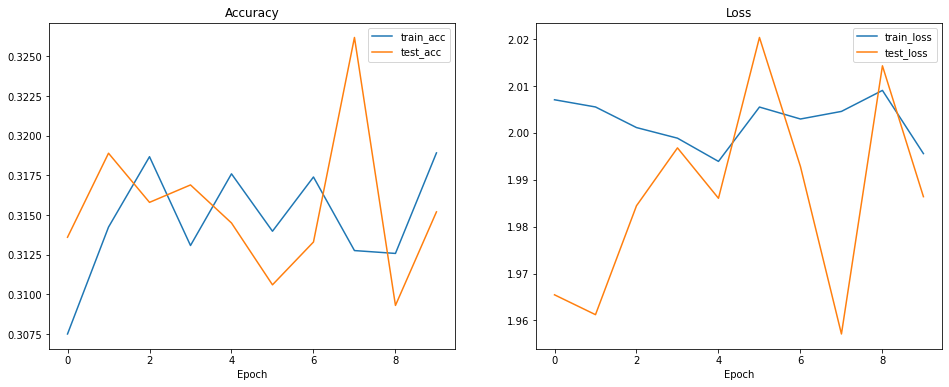

In [22]:
efficientnet_instance.plot()

## [2 points] Comparsion and tuning

Переобучите несколько (не меньше трёх различных) сетей из библиотеки ```torchvision.models```, используя **transfer learning**. Рекомендуется выбрать несколько вариаций одной и той же сети (например, ```resnet``` или ```efficientnet```). 

In [293]:
resnet152 = torchvision.models.resnet152(pretrained=True, progress=True)
for name, param in resnet152.named_parameters():
    param.requires_grad = False

in_features = resnet152.fc.in_features
resnet152.fc = nn.Linear(in_features, 10)
resnet152 = resnet152.to(device)

resnet152_instance = ModelInstance(
    train_dataloader,
    test_dataloader,
    resnet152,
    torch.optim.Adam(resnet152.parameters()),
    nn.CrossEntropyLoss()
)

In [294]:
resnet152_instance.run(10)

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.705111'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 41.5%, Validation loss: 105.667831 

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.573966'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 42.6%, Validation loss: 93.039635 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.453057'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.2%, Validation loss: 143.546066 

Epoch 4
-------------------------------


'[50000/50000] Loss: 1.706046'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 42.0%, Validation loss: 178.634720 

Epoch 5
-------------------------------


'[50000/50000] Loss: 1.395701'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 42.9%, Validation loss: 202.603104 

Epoch 6
-------------------------------


'[50000/50000] Loss: 1.674306'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 41.7%, Validation loss: 197.409805 

Epoch 7
-------------------------------


'[50000/50000] Loss: 1.303550'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 41.8%, Validation loss: 231.008148 

Epoch 8
-------------------------------


'[50000/50000] Loss: 1.666981'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 42.0%, Validation loss: 265.991364 

Epoch 9
-------------------------------


'[50000/50000] Loss: 1.065804'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.6%, Validation loss: 218.178513 

Epoch 10
-------------------------------


'[50000/50000] Loss: 2.224930'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.0%, Validation loss: 234.995941 



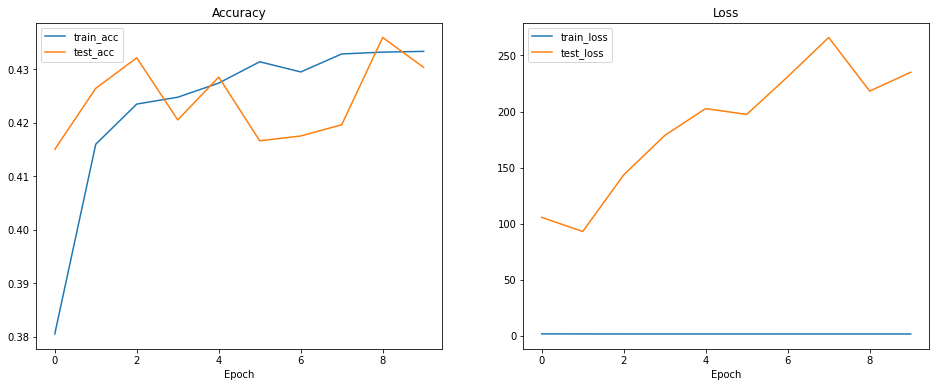

In [625]:
resnet152_instance.plot()

In [627]:
resnet34 = torchvision.models.resnet34(pretrained=True, progress=True)
for name, param in resnet34.named_parameters():
    param.requires_grad = False

in_features = resnet34.fc.in_features
resnet34.fc = nn.Linear(in_features, 10)
resnet34 = resnet34.to(device)

resnet34_instance = ModelInstance(
    train_dataloader,
    test_dataloader,
    resnet34,
    torch.optim.Adam(resnet34.parameters()),
    nn.CrossEntropyLoss()
)

In [628]:
resnet34_instance.run(10)

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.801498'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.5%, Validation loss: 1.736997 

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.479621'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.7%, Validation loss: 1.737509 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.510303'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.4%, Validation loss: 1.742683 

Epoch 4
-------------------------------


'[50000/50000] Loss: 1.649380'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.1%, Validation loss: 1.765663 

Epoch 5
-------------------------------


'[50000/50000] Loss: 1.711153'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 42.7%, Validation loss: 1.763731 

Epoch 6
-------------------------------


'[50000/50000] Loss: 1.680194'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 44.3%, Validation loss: 1.709924 

Epoch 7
-------------------------------


'[50000/50000] Loss: 1.109307'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 44.1%, Validation loss: 1.722313 

Epoch 8
-------------------------------


'[50000/50000] Loss: 1.541572'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.1%, Validation loss: 1.750878 

Epoch 9
-------------------------------


'[50000/50000] Loss: 1.572793'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 43.5%, Validation loss: 1.794067 

Epoch 10
-------------------------------


'[50000/50000] Loss: 1.494203'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 44.0%, Validation loss: 1.710365 



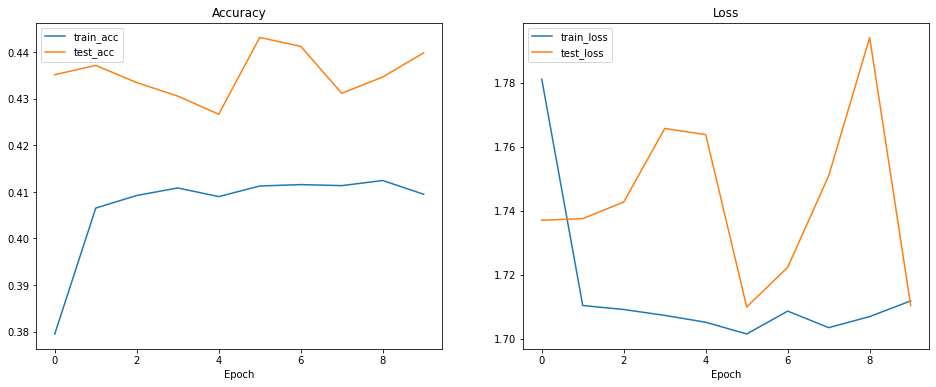

In [630]:
resnet34_instance.plot()

In [632]:
resnet50 = torchvision.models.resnet50(pretrained=True, progress=True)
for name, param in resnet50.named_parameters():
    param.requires_grad = False

in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, 10)
resnet50 = resnet50.to(device)

resnet50_instance = ModelInstance(
    train_dataloader,
    test_dataloader,
    resnet50,
    torch.optim.Adam(resnet50.parameters()),
    nn.CrossEntropyLoss()
)

In [633]:
resnet50_instance.run(10)

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.576906'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 44.1%, Validation loss: 2.041485 

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.821560'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 46.3%, Validation loss: 1.688496 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.262531'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 46.2%, Validation loss: 1.731705 

Epoch 4
-------------------------------


'[50000/50000] Loss: 1.330206'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 46.8%, Validation loss: 1.766794 

Epoch 5
-------------------------------


'[50000/50000] Loss: 1.899018'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 46.5%, Validation loss: 2.299856 

Epoch 6
-------------------------------


'[50000/50000] Loss: 2.190624'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 46.3%, Validation loss: 1.916460 

Epoch 7
-------------------------------


'[50000/50000] Loss: 1.522694'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 46.0%, Validation loss: 2.108482 

Epoch 8
-------------------------------


'[50000/50000] Loss: 1.820362'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 47.2%, Validation loss: 1.754446 

Epoch 9
-------------------------------


'[50000/50000] Loss: 2.010942'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 47.5%, Validation loss: 1.919884 

Epoch 10
-------------------------------


'[50000/50000] Loss: 0.959199'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 48.5%, Validation loss: 1.850520 



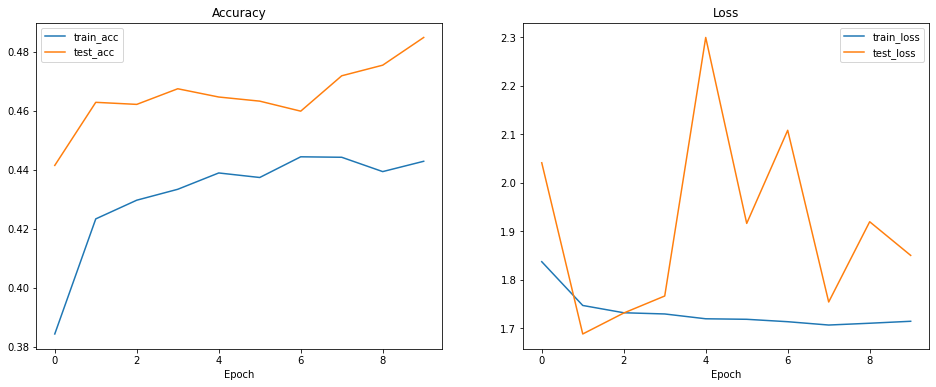

In [635]:
resnet50_instance.plot()

In [566]:
resnet101 = torchvision.models.resnet101(pretrained=True, progress=True)
for name, param in resnet101.named_parameters():
    param.requires_grad = False

in_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(in_features, 10)
resnet101 = resnet101.to(device)

resnet101_instance = ModelInstance(
    train_dataloader,
    test_dataloader,
    resnet101,
    torch.optim.Adam(resnet101.parameters()),
    nn.CrossEntropyLoss()
)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /data/dkkoshman/.local/share/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [567]:
resnet101_instance.run(10)

Epoch 1
-------------------------------


'[20000/50000] Loss: 1.782828'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 42.9%, Validation loss: 27.559759 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.907539'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 41.6%, Validation loss: 27.611673 

Epoch 4
-------------------------------


'[7500/50000] Loss: 1.705661'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 43.9%, Validation loss: 32.661819 

Epoch 8
-------------------------------


'[42500/50000] Loss: 1.705683'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



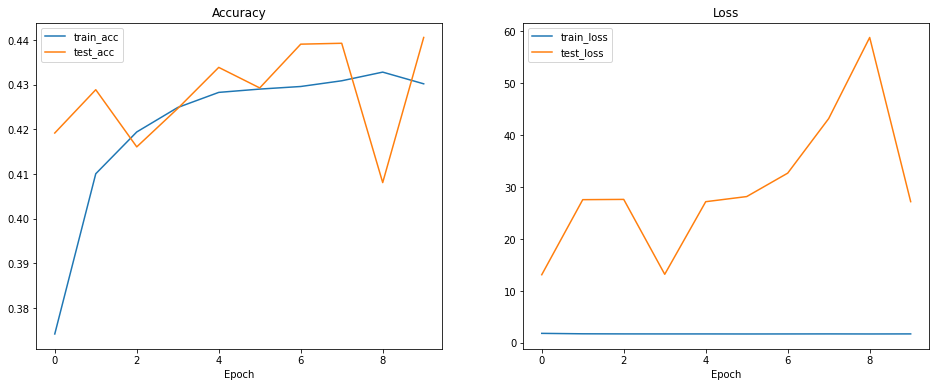

In [636]:
resnet101_instance.plot()

In [638]:
efficientnet_b7 = torchvision.models.efficientnet_b7(pretrained=True, progress=True)
for name, param in efficientnet_b7.named_parameters():
    param.requires_grad = False

in_features = efficientnet_b7.classifier[-1].in_features
efficientnet_b7.classifier[-1] = nn.Linear(in_features, 10)
efficientnet_b7 = efficientnet_b7.to(device)

efficientnet_b7_instance = ModelInstance(
    train_dataloader,
    test_dataloader,
    efficientnet_b7,
    torch.optim.Adam(efficientnet_b7.parameters()),
    nn.CrossEntropyLoss()
)

In [639]:
%time efficientnet_b7_instance.run(10)

Epoch 1
-------------------------------


'[50000/50000] Loss: 2.403729'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.3%, Validation loss: 2.378014 

Epoch 2
-------------------------------


'[50000/50000] Loss: 2.280694'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.2%, Validation loss: 2.392796 

Epoch 3
-------------------------------


'[50000/50000] Loss: 2.428302'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.9%, Validation loss: 2.365701 

Epoch 4
-------------------------------


'[50000/50000] Loss: 2.860243'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.9%, Validation loss: 2.332656 

Epoch 5
-------------------------------


'[50000/50000] Loss: 2.146513'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.6%, Validation loss: 2.483136 

Epoch 6
-------------------------------


'[50000/50000] Loss: 2.618677'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.7%, Validation loss: 2.395955 

Epoch 7
-------------------------------


'[50000/50000] Loss: 2.001012'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 21.0%, Validation loss: 2.457278 

Epoch 8
-------------------------------


'[50000/50000] Loss: 2.501444'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.6%, Validation loss: 2.357456 

Epoch 9
-------------------------------


'[50000/50000] Loss: 2.653893'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.6%, Validation loss: 2.374878 

Epoch 10
-------------------------------


'[50000/50000] Loss: 1.994542'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 20.7%, Validation loss: 2.389106 

CPU times: user 38min 18s, sys: 24.7 s, total: 38min 42s
Wall time: 38min 42s


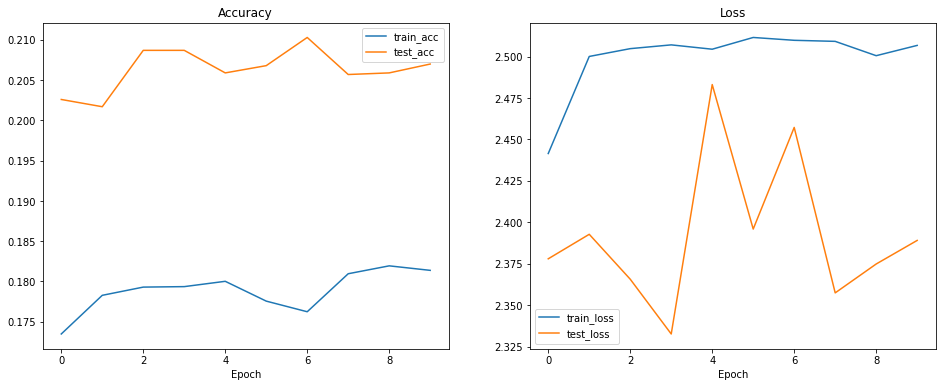

In [641]:
efficientnet_b7_instance.plot()

### [1 point]
Нарисуйте графики зависимости ошибки и точности во время обучения от числа прошедших эпох для всех сетей. 

**Hint 1!** На одном графике должны быть представлены все сети (а также легенда), но только один из четырёх параметров.

**Hint 1.5!** Из предыдущего пункта следует, что графиков должно быть... четыре.

**Hint 2!** Воспользуйтесь возможностью создавать ```subplot``` в библиотеке ```matplotlib```. 

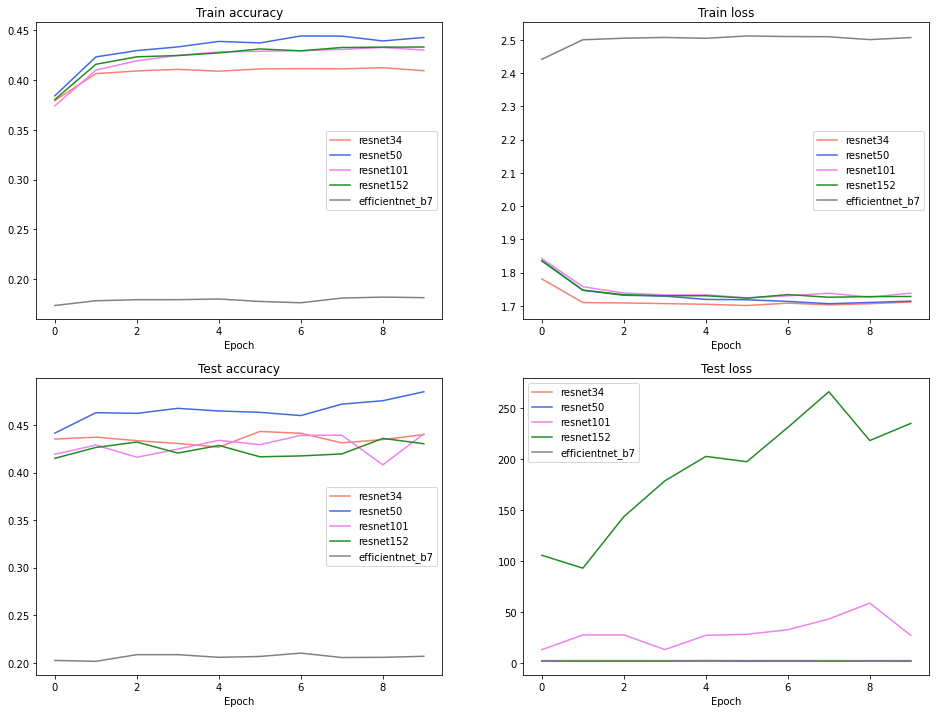

In [642]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

model_plots = [
    (resnet34_instance, 'resnet34', 'salmon'),
    (resnet50_instance, 'resnet50', 'royalblue'),
    (resnet101_instance, 'resnet101', 'violet'),
    (resnet152_instance, 'resnet152', 'forestgreen'),
    (efficientnet_b7_instance, 'efficientnet_b7', 'gray'),
]

stats = [
    ('Train accuracy', 'train_acc'),
    ('Train loss', 'train_loss'),
    ('Test accuracy', 'test_acc'),
    ('Test loss', 'test_loss'),
]

for axis, (stat, attribute) in zip(ax.flatten(), stats):
    axis.set_title(stat)
    for model, name, color in model_plots:
        axis.plot(getattr(model, attribute), label=name, c=color)
    axis.legend()
    axis.set_xlabel('Epoch')


In [ ]:
import pickle

with open('resnets', 'wb') as file:
    pickle.dump(model_plots, file)

 ### [1 point]
Сравните результаты. Как размер и глубина сети влияют на обучение?

In [643]:
def count_depth(module):
    if len(list(module.children())) == 0:
        return 1
    depth = 0
    for name, child in module.named_children():
        if not name.lower().startswith('downsample'):
            depth += count_depth(child)
    return depth

def count_parameters(module):
    return sum([p.numel() for p in module.parameters()])

In [644]:
print(f'{"":20}{"parameters":20}{"depth":10}\n')
for model, name, color in model_plots:
    print(f'{name:20}{f"{count_parameters(model.model) // 10**6} million":20}'
          f'{f"{count_depth(model.model)} layers":10}')

                    parameters          depth     

resnet34            21 million          86 layers 
resnet50            23 million          118 layers
resnet101           42 million          237 layers
resnet152           58 million          356 layers
efficientnet_b7     63 million          767 layers


На графиках можно сразу увидеть, что efficientnet не смогла показать достойный результат даже на обучающих данных, что не удивительно, ведь ее сверточные слои достигают размера 3500x3500, и разрешение изображений в датасете слишком мало для такой сети.

Графики оставшихся сетей показывают похожее поведение, за исключением test_loss - где видно, что сети resnet101 и resnet152 переобучились, и на картинках с голубым небом, изображенных ниже, показывают огромные потери, которые портят все качество. Такой эффект связан с низким рангом матриц, соотвествующих однородному фону на фотографиях, а также с артефактами последнего BatchNorm слоя, бегущая дисперсия которого на обучении мала, что провоцирует его на сильное увеличение ошибки при валидации.

In [ ]:
errors = []
loss_fn = nn.CrossEntropyLoss()

with torch.no_grad():
    resnet152.eval()
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        f = resnet152(X)
        errors.append(max([(loss_fn(ff[None], yy[None]), yy, xx) for ff, yy, xx in zip(f, y, X)],
                          key=lambda x:x[0]))
        
errors_sorted = sorted(m, key=lambda x:x[0], reverse=True)

Images with highest test loss by batch


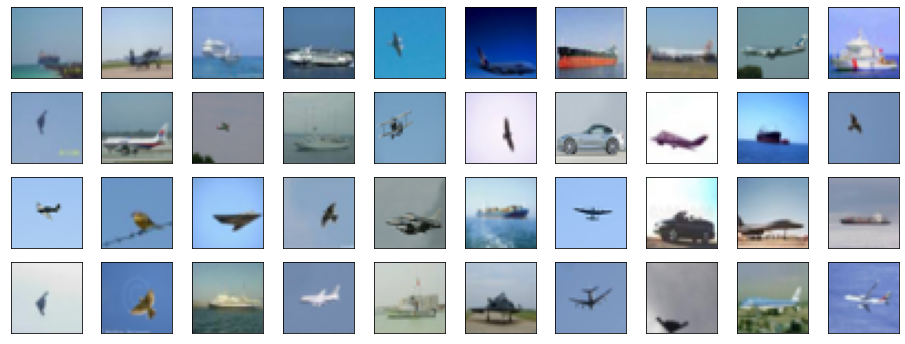

In [719]:
fig, ax = plt.subplots(4, 10, figsize=(16, 6))
ax = ax.flatten()
for i, error in enumerate(errors_sorted[:40]):
    ax[i].imshow(error[2].cpu().transpose(0, 2).transpose(0, 1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
print("Images with highest test loss by batch")

На оставшихся графиках можно заметить, что кривые всех моделей имеют одинаковую форму, и отличаются в основном смещением по вертикальной оси. Это означает, что процесс оптимизации для всех моделей протекает одинаково, а архитектура сетей отличается не качественно, а размером. Это наблюдение позволяет извлечь из графиков информацию о зависимости качества сетей от их размера, поскольку остальные факторы можно считать совпадающими.

Из первого графика можно заключить, что train_acc выпукло зависит от размера сети и достигает максимума на resnet50.

На втором графике видно, что train_loss монотонно растет с ростом размера сети.

test_acc ведет себя также, как train_acc.

Получаем вывод, что для данного датасета из рассмотренных моделей resnet50 обладает оптимальной структурой и эффективной сложностью.

# Bonus Task #4: Deep Double Descent [5 points]

*Несмотря на то, что это задание является бонусным, крайне рекомендуется попробовать его осилить. Оно не настолько страшное, каким кажется со стороны, однако поможет закрепить полученные навыки.*

В этом задании вам предлагается познакомиться с эффектом, называемым [deep double descent](https://arxiv.org/abs/1912.02292). Ознакомительную краткую версию можно найти [тут](https://openai.com/blog/deep-double-descent/).


## 4.1 Network width impact [3 points]

Вы будете исследовать способность нейросети обобщать данные в зависимости от её архитектуры. Чтобы более ясно увидеть эту зависимость, потребуется добавить к обучающим данным некоторое количество шума. 

<img src="./resources/double_descent.png" width="700"/>

### 4.1.1 Adding noise

Необходимо подготовить три различных набора данных из уже доступного вам **CIFAR10**:

    1. В первом все метки классов правильные.
    2. Во втором 10% меток классов случайные.
    3. В третьем 20% меток классов случайные. 

### 4.1.2 Choose basic model

В качесте базовой модели будем использовать **ResNet18**. 

Вам потребуется изменять только количество каналов в каждом свёрточном слое (и, соответственно, размеры линейного слоя в классификаторе). На графике выше по оси абсцисс отмечена "ширина" сети, то есть число каналов входящих в сеть свёрток. Глубина сети, то есть число блоков или входных слоёв, должна остаться _неизменной_.

Начните с небольших свёрток по 4 нейрона на первом слое **ResNet18** и постепенно увеличивайте количество до 128-256 на первом слое. Число нейронов на последующих слоях должно меняться  пропорционально первому слою. Используйте разумный шаг при увеличении числа нейронов для построения графика.

Ваша задача - точно отследить, при каком количестве параметров сеть:

    a) Число параметров слишком мало, сеть не обладает обобщающей способностью.
    b) Число параметров оптимально или близко к оптимальному (первый локальный минимум на графике). 
    c) Число параметров больше, чем необходимо (с увеличением числа параметров значения loss-функции после обучения должны стремиться ко второму минимуму).

### 4.1.3 Compare models

Цель задания - самостоятельно получить такой же график, как и у авторов статьи. Однако в нашем случае мы хотим отрисовать три различных линии на графике: каждой линии должна соответстовать сеть, обученная на своей версии датасета из пункта **4.1.2**.

In [11]:
class RandomDataloader(torch.utils.data.DataLoader):
    def __init__(self, probability):
        self.probability = probability
        
    def __getattr__(self, attr):
        return getattr(train_dataloader, attr)
        
    def __iter__(self):
        for X, y in train_dataloader:
            random_y = torch.randint_like(y, 0, 10)
            mask = torch.bernoulli((torch.ones_like(y) * self.probability).type(torch.float))
            y = (1 - mask) * y + mask * random_y
            X, y = X.to(device), y.type(torch.cuda.LongTensor).to(device)
            yield X, y

In [28]:
import math

start = 3
finish = 32
steps = 8
base = 2
widths = torch.logspace(math.log(start, base), math.log(finish, base), steps, base=base).type(torch.int)
random_probs = [0, .1, .2]
models = [ResNet18(width=width).to(device) for width in widths]

In [14]:
model_instances = [[ModelInstance(
    RandomDataloader(prob),
    test_dataloader,
    model,
    torch.optim.Adam(model.parameters()),
    nn.CrossEntropyLoss()
) for model in models] for prob in random_probs]

In [ ]:
epochs = 10

for models in model_instances[1:]:
    for model in tqdm(models):
        model.model = model.model.to(device)
        model.run(epochs)
        model.model = model.model.to('cpu')
        torch.cuda.empty_cache()

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1
-------------------------------


'[50000/50000] Loss: 0.951610'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 59.2%, Validation loss: 1.169096 

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.250409'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 57.7%, Validation loss: 1.215602 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.501622'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 60.0%, Validation loss: 1.168924 

Epoch 4
-------------------------------


'[50000/50000] Loss: 1.430055'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 60.8%, Validation loss: 1.126545 

Epoch 5
-------------------------------


'[50000/50000] Loss: 1.181243'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 59.9%, Validation loss: 1.155514 

Epoch 6
-------------------------------


'[50000/50000] Loss: 0.960883'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 60.6%, Validation loss: 1.140450 

Epoch 7
-------------------------------


'[50000/50000] Loss: 0.934670'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 59.2%, Validation loss: 1.194106 

Epoch 8
-------------------------------


'[50000/50000] Loss: 0.730714'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 59.3%, Validation loss: 1.166970 

Epoch 9
-------------------------------


'[50000/50000] Loss: 1.423834'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 60.9%, Validation loss: 1.139549 

Epoch 10
-------------------------------


'[50000/50000] Loss: 1.156150'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 60.5%, Validation loss: 1.151120 

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.257176'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 63.4%, Validation loss: 1.069704 

Epoch 2
-------------------------------


'[50000/50000] Loss: 0.906217'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 63.1%, Validation loss: 1.068517 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.030733'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 60.5%, Validation loss: 1.146156 

Epoch 4
-------------------------------


'[50000/50000] Loss: 1.295953'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 64.4%, Validation loss: 1.052998 

Epoch 5
-------------------------------


'[50000/50000] Loss: 1.193647'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 63.9%, Validation loss: 1.050823 

Epoch 6
-------------------------------


'[50000/50000] Loss: 0.898006'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 63.9%, Validation loss: 1.054463 

Epoch 7
-------------------------------


'[50000/50000] Loss: 0.685213'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 64.0%, Validation loss: 1.064603 

Epoch 8
-------------------------------


'[50000/50000] Loss: 1.719912'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 64.8%, Validation loss: 1.043139 

Epoch 9
-------------------------------


'[50000/50000] Loss: 0.993403'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 64.5%, Validation loss: 1.031772 

Epoch 10
-------------------------------


'[50000/50000] Loss: 1.362583'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 63.1%, Validation loss: 1.081074 

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.039060'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 66.3%, Validation loss: 0.984082 

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.066274'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 66.9%, Validation loss: 0.972469 

Epoch 3
-------------------------------


'[50000/50000] Loss: 0.341539'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 65.3%, Validation loss: 1.018559 

Epoch 4
-------------------------------


'[50000/50000] Loss: 1.081095'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 66.6%, Validation loss: 0.990195 

Epoch 5
-------------------------------


'[50000/50000] Loss: 1.335810'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 66.8%, Validation loss: 0.975852 

Epoch 6
-------------------------------


'[50000/50000] Loss: 1.145953'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 67.4%, Validation loss: 0.977186 

Epoch 7
-------------------------------


'[50000/50000] Loss: 0.628015'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 67.7%, Validation loss: 0.965371 

Epoch 8
-------------------------------


'[50000/50000] Loss: 0.942547'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 64.6%, Validation loss: 1.045054 

Epoch 9
-------------------------------


'[27499/50000] Loss: 0.549272'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 66.7%, Validation loss: 0.991320 

Epoch 1
-------------------------------


'[30000/50000] Loss: 1.834010'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

In [26]:
data = [[{'train_acc': [], 'train_loss': [], 'test_acc':[], 'test_loss':[]} for model in models] for prob in random_probs]

for models, dat in zip(model_instances, data):
    for model, dt in zip(models, dat):
        dt['train_acc'] = model.train_acc
        dt['train_loss'] = model.train_loss
        dt['test_acc'] = model.test_acc
        dt['test_loss'] = model.test_loss

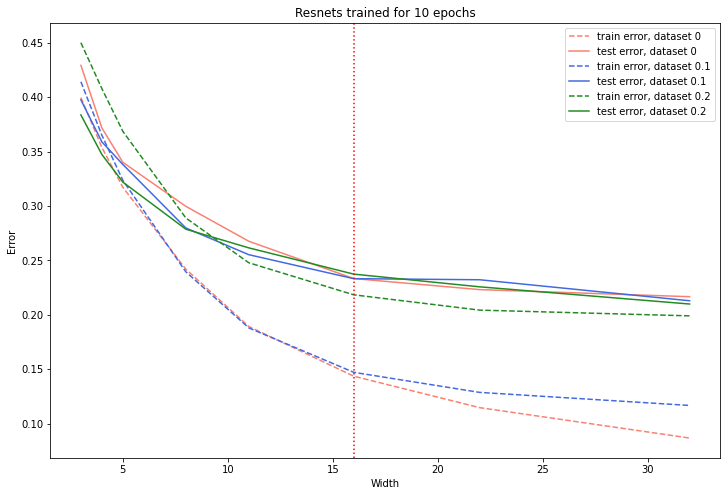

In [72]:
window = 3
fig = plt.figure(figsize=(12, 8))
plt.title(f"Resnets trained for {epochs} epochs")

for prob, data_prob, color in zip(random_probs, data, ['salmon', 'royalblue', 'forestgreen']):
    plt.plot(widths, [1. - sum(dt['train_acc'][-window:]) / window for dt in data_prob],
             '--', label=f'train error, dataset {prob}', c=color)
    plt.plot(widths, [1. - sum(dt['test_acc'][-window:]) / window for dt in data_prob],
             label=f'test error, dataset {prob}', c=color)
    plt.legend()
    plt.xlabel('Width')
    plt.ylabel('Error')
    
plt.axvline(16, ls=':', c='red');

Эффект двойного минимума здесь не особо заметен, поскольку сети обучались только 10 эпох и не уперлись в потолок эффективной сложности. Для сравнения, в работе [deep double descent](https://arxiv.org/abs/1912.02292) двойное дно стало заметно только после порядка 100 эпох. Тем не менее виден выход на плато в районе количества параметров, соответствующему 16 нейронам на первом слое. Можно предположить, что это плато соответсвует интерполяционному порогу - то есть такой сложности сети, что она максимально близка к сложности истинной зависимости.

Почему может возникать такой эффект? Возможно, потому что если две модели имеют одинаковую структуру, но разную спецификацию, то ошибка в спецификации транслируется на всю структуру, и накапливается в большие потери. Например, пусть мы хотим приблизить движение стрелки часов с 10 до 15 минут. Если взять недопараметризованную модель - сломанные часы, то можно поставить стрелку на 12.5 минут и получить среднюю ошибку в 2.5 минуты. Если взять правильную модель - рабочие часы - но неправильно поставить время на них - так, что они отстают на 3 минуты, то мы получим бòльшую ошибку, несмотря на то, что модель верная. Ну и если взять перепараметризованную модель - человека, то он может сидеть и повторять движение стрелки с большой точностью, но это неадекватное решение задачи.

Еще эта ситуация напоминает так называемый эффект [uncanny valley](https://en.wikipedia.org/wiki/Uncanny_valley) - там мера схожести с человеком имеет двойной максимум, причем антропоморфные роботы (оптимальная сложность модели) вызывают больше когнитивного диссонанса, чем куклы (underparametrization) или компьютерные супергерои в фильмах (overparametrization).

Проведем более строгий анализ на примере игрального кубика. Пусть дан кубик, у которого вероятность выпадение числа меньше 4 равна 1/3, то есть у него 1 параметр. Будем приближать его обычным кубиком - моделью без параметров; кубиком с вероятностью выпадения четного числа p - модель с 1 параметром, неправильная спецификация; кубиком с вероятностью выпадения числа меньше 4 равна p - модель с 1 параметром, правильная спецификация; кубиком с вероятностью выпадения единицы p1, двойки или четверки - p2 - модель с 2 параметрами.

In [127]:
p = 1/3
x = np.linspace(0.1, .6, 100)
true_distribution = [p/3, p/3, p/3, (1-p)/3, (1-p)/3, (1-p)/3]

def entropy(first, second):
    return sum([-p1*np.log(p2) for p1, p2 in zip(first, second)])

def under_parametrized(xx):
    return [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]

def incorrect_specification(xx):
    return [xx/3, (1-xx)/3, xx/3, (1-xx)/3, xx/3, (1-xx)/3]

def correct_specification(xx):
    return [xx/3, xx/3, xx/3, (1-xx)/3, (1-xx)/3, (1-xx)/3]

def over_parametrized(xx):
    min_y = np.argmin([entropy(true_distribution, [yy/3, (1-yy)/3, xx/3, (1-xx)/3, xx/3, (1-xx)/3])
                    for yy in x])
    yy = x[min_y]
    return [yy/3, (1-yy)/3, xx/3, (1-xx)/3, xx/3, (1-xx)/3]

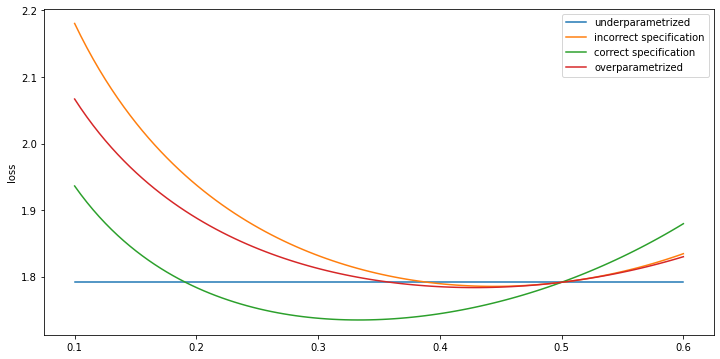

In [128]:
plt.figure(figsize=(12, 6))
plt.plot(x, [entropy(true_distribution, under_parametrized(xx)) for xx in x], label='underparametrized')
plt.plot(x, [entropy(true_distribution, incorrect_specification(xx)) for xx in x], label='incorrect specification')
plt.plot(x, [entropy(true_distribution, correct_specification(xx)) for xx in x], label='correct specification')
plt.plot(x, [entropy(true_distribution, over_parametrized(xx)) for xx in x], label='overparametrized')
plt.ylabel('loss')
plt.legend();

Видно, что несмотря на правильную сложность модели, некорректная спецификация показывает худшие результаты.

## 4.2 Network samples impact [2 points]

Это задание похоже на предыдущее: однако, в этом случае вы будем исследовать зависимость эффекта не от ширины сети, а от размера обучающей выборки. 

<img src="./resources/sample_wise_double_descent.svg" width="700"/>

### 4.2.1 Truncate dataset

Необходимо подготовить два различных набора данных из уже доступного вам **CIFAR10**:

    1. Полный датасет без изменений.
    2. 40% от датасета. 
    
### 4.2.2 Compare models


Аналогично **4.1**, глубина и топология сети должны оставаться неизменными; от вас снова требуется изменять только число нейронов в свёртках. Шаг и сетку параметров можно использовать такую же, как и пункте **4.1**.

Для каждого значения "ширины" сети требуется отметить две точки: значение **loss**-функции при обучении на полном датасете и на частичном. 


Так же как и в прошлом задании, вы можете опираться на результат авторов статьи (пример расположен выше). 

In [144]:
def truncated_train_dl(proportion):
    indices = torch.randperm(len(train_data))[:round(len(train_data) * proportion)]
    train_data_subset = torch.utils.data.Subset(train_data, indices)
    return torch.utils.data.DataLoader(
        train_data_subset, shuffle=True, 
        batch_size=batch_size, num_workers=num_workers
    )

In [146]:
train_dls = [train_dataloader, truncated_train_dl(proportion=.4)]
models = [[ResNet18(width=width) for width in widths] for train_dl in train_dls]
model_instances = [[ModelInstance(
    train_dl,
    test_dataloader,
    models[j][i],
    torch.optim.Adam(models[j][i].parameters()),
    nn.CrossEntropyLoss()
) for i, width in enumerate(widths)] for j, train_dl in enumerate(train_dls)]

In [147]:
epochs = 5

for models in model_instances:
    for model in tqdm(models):
        model.model = model.model.to(device)
        model.run(epochs)
        model.model = model.model.to('cpu')
        torch.cuda.empty_cache()

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.375794'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 42.2%, Validation loss: 1.556577 

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.250644'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 48.5%, Validation loss: 1.410328 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.452441'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 54.4%, Validation loss: 1.285987 

Epoch 4
-------------------------------


'[50000/50000] Loss: 1.775932'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 54.3%, Validation loss: 1.274784 

Epoch 5
-------------------------------


'[50000/50000] Loss: 1.295756'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 52.5%, Validation loss: 1.348113 

Epoch 1
-------------------------------


'[40000/50000] Loss: 1.409431'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 55.2%, Validation loss: 1.254732 

Epoch 4
-------------------------------


'[47500/50000] Loss: 0.984580'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 58.4%, Validation loss: 1.167780 

Epoch 4
-------------------------------


'[47500/50000] Loss: 1.082809'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 60.6%, Validation loss: 1.119210 

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.366340'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 49.7%, Validation loss: 1.384513 

Epoch 2
-------------------------------


'[50000/50000] Loss: 1.316434'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 60.8%, Validation loss: 1.080261 

Epoch 3
-------------------------------


'[50000/50000] Loss: 1.195371'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 64.9%, Validation loss: 0.994965 

Epoch 4
-------------------------------


'[50000/50000] Loss: 0.819014'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 66.1%, Validation loss: 0.968742 

Epoch 5
-------------------------------


'[50000/50000] Loss: 0.811027'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 64.6%, Validation loss: 1.018139 

Epoch 1
-------------------------------


'[50000/50000] Loss: 1.054916'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 57.2%, Validation loss: 1.186533 

Epoch 2
-------------------------------


'[50000/50000] Loss: 0.873104'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 64.8%, Validation loss: 1.011236 

Epoch 3
-------------------------------


'[50000/50000] Loss: 0.593287'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 66.3%, Validation loss: 0.956035 

Epoch 4
-------------------------------


'[50000/50000] Loss: 0.546316'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 68.4%, Validation loss: 0.895372 

Epoch 5
-------------------------------


'[2500/50000] Loss: 0.926267'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 57.8%, Validation loss: 1.182254 

Epoch 2
-------------------------------


'[0/50000] Loss: 0.766286'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 53.0%, Validation loss: 1.438037 

Epoch 2
-------------------------------


'[50000/50000] Loss: 0.506766'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation accuracy: 66.9%, Validation loss: 0.973930 

Epoch 3
-------------------------------


'[37500/50000] Loss: 0.877324'

Batch #:   0%|          | 0/3125 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 44.1%, Validation loss: 1.516126 

Epoch 4
-------------------------------


'[20000/20000] Loss: 1.527270'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 46.9%, Validation loss: 1.448871 

Epoch 5
-------------------------------


'[20000/20000] Loss: 1.315401'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 48.3%, Validation loss: 1.415440 

Epoch 1
-------------------------------


'[20000/20000] Loss: 1.728688'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 40.8%, Validation loss: 1.632060 

Epoch 2
-------------------------------


'[6000/20000] Loss: 1.987024'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 53.9%, Validation loss: 1.280421 

Epoch 5
-------------------------------


'[20000/20000] Loss: 1.125109'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 50.5%, Validation loss: 1.456006 

Epoch 1
-------------------------------


'[20000/20000] Loss: 1.603476'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 43.2%, Validation loss: 1.543437 

Epoch 2
-------------------------------


'[20000/20000] Loss: 1.332711'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 56.1%, Validation loss: 1.225976 

Epoch 3
-------------------------------


'[20000/20000] Loss: 1.287656'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 57.7%, Validation loss: 1.187225 

Epoch 4
-------------------------------


'[0/20000] Loss: 1.007443'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 50.9%, Validation loss: 1.361109 

Epoch 2
-------------------------------


'[20000/20000] Loss: 1.328861'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 55.8%, Validation loss: 1.248664 

Epoch 3
-------------------------------


'[20000/20000] Loss: 1.492239'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 58.5%, Validation loss: 1.175331 

Epoch 4
-------------------------------


'[20000/20000] Loss: 0.917044'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 61.9%, Validation loss: 1.087521 

Epoch 5
-------------------------------


'[17000/20000] Loss: 1.172814'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 55.0%, Validation loss: 1.321333 

Epoch 4
-------------------------------


'[20000/20000] Loss: 0.578637'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 61.6%, Validation loss: 1.104008 

Epoch 5
-------------------------------


'[20000/20000] Loss: 0.615181'

Batch #:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation accuracy: 67.8%, Validation loss: 0.930482 



In [153]:
data2 = [[{'train_acc': [], 'train_loss': [], 'test_acc':[], 'test_loss':[]} for width in widths] for train_dl in train_dls]

for models, dat in zip(model_instances, data2):
    for model, dt in zip(models, dat):
        dt['train_acc'] = model.train_acc
        dt['train_loss'] = model.train_loss
        dt['test_acc'] = model.test_acc
        dt['test_loss'] = model.test_loss

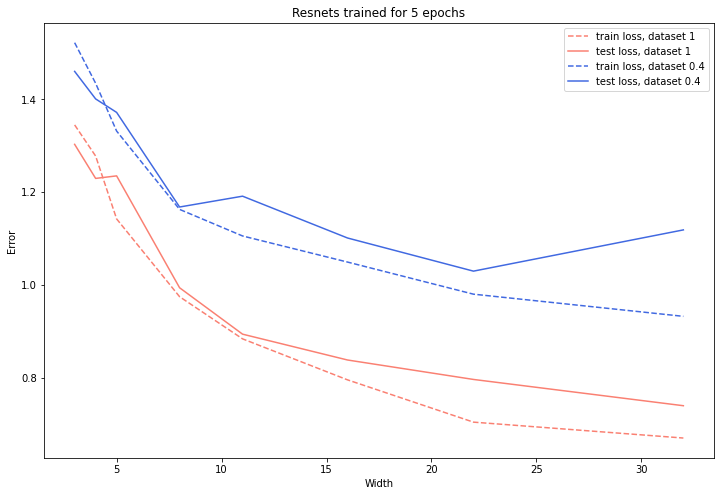

In [159]:
window = 3
fig = plt.figure(figsize=(12, 8))
plt.title(f"Resnets trained for {epochs} epochs")

for proportion, data_prob, color in zip([1, .4], data2, ['salmon', 'royalblue']):
    plt.plot(widths, [sum(dt['train_loss'][-window:]) / window for dt in data_prob],
             '--', label=f'train loss, dataset {proportion}', c=color)
    plt.plot(widths, [sum(dt['test_loss'][-window:]) / window for dt in data_prob],
             label=f'test loss, dataset {proportion}', c=color)
    plt.legend()
    plt.xlabel('Width')
    plt.ylabel('Error')

В данных условиях локальный максимум в районе эффективной сложности модели не наблюдается.